### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import os
from datetime import datetime
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR
import torchvision
from torchvision import models
from apex import amp

from albumentations import Compose, Normalize
from albumentations.pytorch import ToTensorV2, ToTensor

from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

import cv2
import skimage.io
import IPython.display as display
from PIL import Image

plt.ion()
%matplotlib inline
%config InlineBackend.figure_format='retina'

#### Local Imports

In [3]:
# Paths
from chestxray.config import (PANDA_PATH,
                              MODEL_PATH,
                              PANDA_IMGS,
                              PANDA_MASKS,
                              TRAIN_CSV)
# Competition related config
from chestxray.config import CFG

# Misc
from chestxray.misc import seed_torch

# Datasets
from chestxray.datasets import get_transforms, TrainDataset, TilesTrainDataset, LazyTilesDataset

# Viz
from chestxray.visualize import (show_from_ids, show_batch, imshow, 
                                 plot_classes_preds, reverse_show_img, 
                                 plot_confusion_matrix)

# Nets
from chestxray.nets import TinyV2ConvNet, make_RN50_cls, freeze_botom
from chestxray.model_utils import (trainable_params, cce_loss_at_init, 
                                   init_last_layer_bias)
# Losses
from chestxray.losses import LabelSmoothSoftmaxCEV1

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
print(torch.cuda.get_device_properties(device))

_CudaDeviceProperties(name='GeForce RTX 2070 SUPER', major=7, minor=5, total_memory=7979MB, multi_processor_count=40)


### Fix Random Seed

In [6]:
seed_torch()

### Load Data

In [7]:
TRAIN_DF = pd.read_csv(TRAIN_CSV)
TRAIN_DF.head()

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


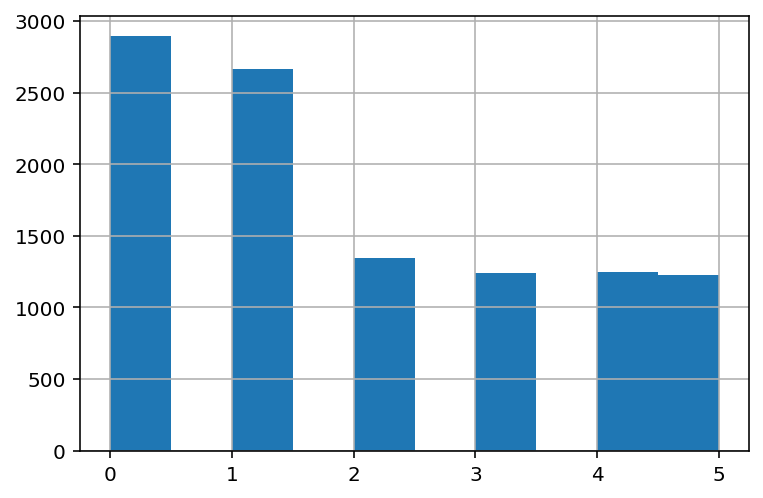

In [8]:
_ = TRAIN_DF[CFG.target_col].hist()

### Define Global Variables

In [9]:
CFG.debug = False
now = datetime.now()

EXP_NAME = now.strftime("%d-%m-%Y-%H-%M")
print(EXP_NAME)

15-05-2020-20-37


In [10]:
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter(f'runs/{EXP_NAME}')

In [11]:
LOSSES = {
    "cce" : nn.CrossEntropyLoss(),
    "ls_soft_ce" : LabelSmoothSoftmaxCEV1(),
}

In [12]:
# key - string, value - tuple(sceduler, if it epoch type)
epoch_type = True
SCHEDULERS = {
    "reduce_on_plateau" : (ReduceLROnPlateau, epoch_type),
    "one_cycle": (OneCycleLR, not epoch_type),
}

### Train Eval Loop

In [13]:
def train_eval_loop(train_dataloader, val_dataloader, model, optimizer, criterion, scheduler, sch_is_epoch_type,
                    num_epochs=CFG.epoch, device=device, tb_tag="", model_name="debug"):
    """Split it into the set of inner functions to siplify the loop itself"""
    # Inner Functions
    # write to TensorBoard helpers
    def weights_to_tb(step=0):
        conv1_weight = model.conv1.weight.data.to("cpu")
        img_grid = torchvision.utils.make_grid(conv1_weight, normalize=True)
        writer.add_image(tag=f"Model conv1 weights {tb_tag}", img_tensor=img_grid, global_step=step)
    
    def input_img_to_tb(inputs, step):
        img = reverse_show_img(inputs[0])
        writer.add_image(tag=f"Input Image {tb_tag}", img_tensor=img, global_step=step, dataformats="HWC")
        del img
    
    def preds_to_tb(outputs, inputs, labels, step):
        figure=plot_classes_preds(outputs.to('cpu'), inputs.to('cpu'), labels.to('cpu'))
        writer.add_figure(tag=f"Actuals vs Predictions {tb_tag}", figure=figure, global_step=step)
        
    def metrics_to_tb(mode, train_loss, train_score, val_loss, val_score, step):
        writer.add_text(f"On best {mode} save:", 
                        f"tr_loss: {train_loss:.4f}, tr_qwk: {train_score:.4f}, val_loss: {val_loss:.4f}, val_qwk: {val_score:.4f}", 
                        global_step=step)
    
    def conf_matrix_to_tb(val_epoch_labels, val_epoch_preds, step):
        writer.add_figure(tag=f"Confusion matrix {tb_tag}", figure=plot_confusion_matrix(val_epoch_labels, val_epoch_preds),
                          global_step=step)
        
        
    
    # Train/Eval Loop
    # write first layer weights to TB @ init phase
    if not CFG.debug:
        weights_to_tb()
    
    # prepare model and optimizer
    model.to(device)
    if CFG.use_amp: # automatic mixed precision
        model, optimizer = amp.initialize(model, optimizer, opt_level="O1")
    # define epochs numbers to look into input images and predictions, no more than 10 times per full training
    vis_step = np.ceil(num_epochs/10).astype(int)
    visual_epochs = list(range(0, num_epochs, vis_step))
    # metrics to wathch for model checkpointing
    best_qwk = -100
    best_val_loss = np.inf
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('=' * 10)

        # Training Phase
        # Set training mode
        model.train();
        train_running_loss = 0.0
        train_epoch_preds, train_epoch_labels = [], []

        # Iterate over train data.
        tk_train = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
        for i, data in tk_train:
            # Calculate global step for TensorBoard
            train_global_step = epoch * len(train_dataloader) + i

            inputs, labels = data
            # Visualize input before model at the middle of epoch:
            if epoch in visual_epochs and i == len(train_dataloader) // 2:
                input_img_to_tb(inputs, train_global_step)

            inputs = inputs.to(device)
            labels = labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            if CFG.use_amp:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()
            optimizer.step()
            # loss is mean across batch, divide by number of steps in epoch (so loss is normalized)
            train_running_loss += loss.item() / len(train_dataloader)
            # tensorboarding loss
            writer.add_scalar(tag=f"Training loss {tb_tag}", scalar_value=loss.item(), global_step=train_global_step)

            # collect train preds and labels for QWK
            train_epoch_preds.append(outputs.data.to('cpu').numpy().argmax(1))
            train_epoch_labels.append(labels.to('cpu').numpy())
            # Add Batch Type Scheduler step here:
            if not sch_is_epoch_type:
                scheduler.step()
        # Validation Phase
        # Set evaluation mode
        model.eval();
        val_running_loss = 0.0
        val_epoch_preds, val_epoch_labels = [], []
        # Iterate over val data
        tk_val = tqdm(enumerate(val_dataloader), total=len(val_dataloader))
        for j, data in tk_val:
            # Calculate global step
            val_global_step = epoch * len(val_dataloader) + j
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            with torch.no_grad():
                outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() / len(val_dataloader)
            # tensorboarding loss
            writer.add_scalar(tag=f"Validation loss {tb_tag}", scalar_value=loss.item(), global_step=val_global_step)

            # collect validation preds and labels for QWK
            val_epoch_preds.append(outputs.data.to('cpu').numpy().argmax(1))
            val_epoch_labels.append(labels.to('cpu').numpy())

            # visualise predictions for 0th validation batch
            if epoch in visual_epochs and j == 0:
                preds_to_tb(outputs, inputs, labels, val_global_step)
        
        # Epoch type Schedulers
        if sch_is_epoch_type:
            scheduler.step(val_running_loss)
        # Write lr to TBD
        if CFG.finetune == "1stage":
            writer.add_scalar(tag=f"lr Interim {tb_tag}:", scalar_value=optimizer.param_groups[0]["lr"], global_step=train_global_step)
            writer.add_scalar(tag=f"lr Classifier {tb_tag}:", scalar_value=optimizer.param_groups[1]["lr"], global_step=train_global_step)
            
        else:
            writer.add_scalar(tag=f"lr {tb_tag}:", scalar_value=optimizer.param_groups[0]["lr"], global_step=train_global_step)
        
        # "End of Epoch" Phase
        print(f'Training Loss: {train_running_loss:.4f}\tValidation Loss: {val_running_loss:.4f}')
        
        # Calculate epoch predictions distribution
        train_epoch_preds = np.concatenate(train_epoch_preds)
        train_epoch_labels = np.concatenate(train_epoch_labels)
        val_epoch_preds = np.concatenate(val_epoch_preds)
        val_epoch_labels = np.concatenate(val_epoch_labels)
        print(f'Counter train preds: {Counter(train_epoch_preds)}\tCounter val preds: {Counter(val_epoch_preds)}')
        # Calculate epoch QWK
        train_qwk = cohen_kappa_score(train_epoch_preds, train_epoch_labels, weights='quadratic')
        val_qwk = cohen_kappa_score(val_epoch_preds, val_epoch_labels, weights='quadratic')
        print(f"Epoch train QWK: {train_qwk:.3f}\tval QWK: {val_qwk:.3f}")
        writer.add_scalar(tag=f"Training QWK {tb_tag}", scalar_value=train_qwk, global_step=epoch)
        writer.add_scalar(tag=f"Validation QWK {tb_tag}", scalar_value=val_qwk, global_step=epoch)
        
        # On the best val loss do:
        if val_running_loss < best_val_loss:
            # update best and save model
            best_val_loss = val_running_loss
            print(f'  Epoch {epoch} - Save Best Loss: {best_val_loss:.4f} Model')
            torch.save(model.state_dict(), f'{MODEL_PATH}/{model_name}_loss.pth')
            # add losses as text to TB
            metrics_to_tb("loss", train_running_loss, train_qwk, val_running_loss, val_qwk, val_global_step)
            # add image of conv1 weights to TB
            if not CFG.debug:
                weights_to_tb(val_global_step)
            # add confusion matrix to TB
            conf_matrix_to_tb(val_epoch_labels, val_epoch_preds, val_global_step)
        # On the best QWK
        if val_qwk > best_qwk:
            # update best and save model
            best_qwk = val_qwk
            print(f'  Epoch {epoch} - Save Best QWK: {best_qwk:.4f} Model')
            torch.save(model.state_dict(), f'{MODEL_PATH}/{model_name}_qwk.pth')
            # add losses and qwk as text to TB
            metrics_to_tb("qwk", train_running_loss, train_qwk, val_running_loss, val_qwk, val_global_step)
            # add image of conv1 weights to TB
            if not CFG.debug:
                weights_to_tb(val_global_step)  
            # add confusion matrix to TB
            conf_matrix_to_tb(val_epoch_labels, val_epoch_preds, val_global_step)
    # End of loop
    writer.close()

### Prepare CV - strategy

In [14]:
if CFG.debug:
    folds_fn = "folds_db.csv"
    try: 
        folds = pd.read_csv(PANDA_PATH/folds_fn)
    except FileNotFoundError:
        folds = TRAIN_DF.sample(n=100, random_state=CFG.seed).reset_index(drop=True).copy()
else:
    folds_fn = "folds.csv"
    try:
        folds = pd.read_csv(PANDA_PATH/folds_fn)
    except FileNotFoundError:
        folds = TRAIN_DF.copy()

In [15]:
if not (PANDA_PATH/folds_fn).exists():
    train_labels = folds[CFG.target_col].values
    kf = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
    for fold, (train_index, val_index) in enumerate(kf.split(folds.values, train_labels)):
        folds.loc[val_index, 'fold'] = int(fold)
    folds['fold'] = folds['fold'].astype(int)
    folds.to_csv(PANDA_PATH/folds_fn, index=None)
    folds.head()

In [16]:
folds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10616 entries, 0 to 10615
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image_id       10616 non-null  object
 1   data_provider  10616 non-null  object
 2   isup_grade     10616 non-null  int64 
 3   gleason_score  10616 non-null  object
 4   fold           10616 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 414.8+ KB


### Debug Runs

In [18]:
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter(f'runs/debug')

In [19]:
print(" ".join([f"{key}: {val}" for key, val in CFG.__dict__.items() if not key.startswith("__")]))

debug: False use_amp: True img_height: 512 img_width: 512 lr: 0.0001 batch_size: 16 epoch: 50 seed: 1982 target_size: 6 img_id_col: image_id target_col: isup_grade n_fold: 4 tiff_layer: 1 loss: ls_soft_ce


In [18]:
writer.add_text("Experiment Description:", " ".join([f"{key}: {val}" for key, val in CFG.__dict__.items() if not key.startswith("__")]))

In [22]:
train_df = folds[folds["fold"] != 0].copy()
val_df = folds[folds["fold"] == 0].copy()
train_ds = LazyTilesDataset(train_df, transform=get_transforms(data="train", aug="heavy"), debug=False) # NOTE! it is predefined 36-tiles images
val_ds = LazyTilesDataset(val_df, transform=get_transforms(data="valid"), debug=False)

model_ft = make_RN50_cls()
# initialize bias in the model
cls_probas = (train_df[CFG.target_col].value_counts() / len(train_df)).values
model_ft = init_last_layer_bias(model_ft, cls_probas)

criterion = LOSSES[CFG.loss]
optimizer = torch.optim.Adam(model_ft.parameters(), lr=CFG.lr, amsgrad=False)
train_eval_loop(train_ds, val_ds, model_ft, optimizer, criterion, num_epochs=30)

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Epoch 0/29


100%|██████████| 166/166 [00:15<00:00, 10.67it/s]


Training Loss: 1.4133	Validation Loss: 1.3378
Counter train preds: Counter({0: 3171, 1: 2178, 5: 974, 3: 583, 4: 559, 2: 497})	Counter val preds: Counter({1: 964, 0: 951, 2: 237, 4: 185, 3: 164, 5: 153})
Epoch train QWK: 0.590	val QWK: 0.636
  Epoch 0 - Save Best Loss: 1.3378 Model
Confusion matrix, without normalization
[[612 104   1   1   2   3]
 [171 461  26   6   1   1]
 [ 38 220  61  10   4   2]
 [ 41  82  90  60  23  15]
 [ 50  69  31  37  95  31]
 [ 39  28  28  50  60 101]]
  Epoch 0 - Save Best QWK: 0.6357 Model
Confusion matrix, without normalization
[[612 104   1   1   2   3]
 [171 461  26   6   1   1]
 [ 38 220  61  10   4   2]
 [ 41  82  90  60  23  15]
 [ 50  69  31  37  95  31]
 [ 39  28  28  50  60 101]]
Epoch 1/29


100%|██████████| 166/166 [00:14<00:00, 11.12it/s]


Training Loss: 1.3243	Validation Loss: 1.2604
Counter train preds: Counter({0: 3068, 1: 2105, 5: 931, 3: 659, 4: 614, 2: 585})	Counter val preds: Counter({0: 1165, 5: 408, 1: 357, 2: 345, 3: 195, 4: 184})
Epoch train QWK: 0.663	val QWK: 0.723
  Epoch 1 - Save Best Loss: 1.2604 Model
Confusion matrix, without normalization
[[694  10   2   1   7   9]
 [271 243 116  20  13   3]
 [ 64  69 137  37  19   9]
 [ 47  18  54  85  32  75]
 [ 51  14  22  32  88 106]
 [ 38   3  14  20  25 206]]
  Epoch 1 - Save Best QWK: 0.7233 Model
Confusion matrix, without normalization
[[694  10   2   1   7   9]
 [271 243 116  20  13   3]
 [ 64  69 137  37  19   9]
 [ 47  18  54  85  32  75]
 [ 51  14  22  32  88 106]
 [ 38   3  14  20  25 206]]
Epoch 2/29


100%|██████████| 166/166 [00:14<00:00, 11.36it/s]


Training Loss: 1.2768	Validation Loss: 1.2445
Counter train preds: Counter({0: 2990, 1: 2062, 5: 903, 4: 712, 2: 654, 3: 641})	Counter val preds: Counter({0: 988, 1: 664, 5: 486, 3: 310, 4: 129, 2: 77})
Epoch train QWK: 0.694	val QWK: 0.724
  Epoch 2 - Save Best Loss: 1.2445 Model
Confusion matrix, without normalization
[[652  50   1   2   7  11]
 [178 413  27  28  11   9]
 [ 37 139  36  81  13  29]
 [ 43  31   6 118  19  94]
 [ 40  26   6  55  64 122]
 [ 38   5   1  26  15 221]]
  Epoch 2 - Save Best QWK: 0.7243 Model
Confusion matrix, without normalization
[[652  50   1   2   7  11]
 [178 413  27  28  11   9]
 [ 37 139  36  81  13  29]
 [ 43  31   6 118  19  94]
 [ 40  26   6  55  64 122]
 [ 38   5   1  26  15 221]]
Epoch 3/29


100%|██████████| 166/166 [00:16<00:00, 10.25it/s]


Training Loss: 1.2524	Validation Loss: 1.2349
Counter train preds: Counter({0: 2952, 1: 2107, 5: 934, 3: 729, 4: 638, 2: 602})	Counter val preds: Counter({1: 836, 0: 797, 5: 349, 3: 253, 4: 229, 2: 190})
Epoch train QWK: 0.708	val QWK: 0.764
  Epoch 3 - Save Best Loss: 1.2349 Model
Confusion matrix, without normalization
[[583 127   1   0   7   5]
 [118 459  66  14   9   0]
 [ 22 150  84  61  10   8]
 [ 25  42  21 112  56  55]
 [ 21  46  14  38 112  82]
 [ 28  12   4  28  35 199]]
  Epoch 3 - Save Best QWK: 0.7642 Model
Confusion matrix, without normalization
[[583 127   1   0   7   5]
 [118 459  66  14   9   0]
 [ 22 150  84  61  10   8]
 [ 25  42  21 112  56  55]
 [ 21  46  14  38 112  82]
 [ 28  12   4  28  35 199]]
Epoch 4/29


100%|██████████| 166/166 [00:15<00:00, 10.78it/s]

Training Loss: 1.2235	Validation Loss: 1.2475
Counter train preds: Counter({0: 2866, 1: 2110, 5: 923, 4: 713, 3: 677, 2: 673})	Counter val preds: Counter({0: 1068, 1: 627, 4: 370, 3: 248, 5: 245, 2: 96})
Epoch train QWK: 0.727	val QWK: 0.739
Epoch 5/29



100%|██████████| 166/166 [00:14<00:00, 11.65it/s]


Training Loss: 1.2193	Validation Loss: 1.2217
Counter train preds: Counter({0: 2865, 1: 2125, 5: 921, 3: 716, 4: 712, 2: 623})	Counter val preds: Counter({1: 887, 0: 850, 3: 307, 4: 232, 2: 218, 5: 160})
Epoch train QWK: 0.735	val QWK: 0.727
  Epoch 5 - Save Best Loss: 1.2217 Model
Confusion matrix, without normalization
[[616  87   2   3   9   6]
 [134 488  24  17   3   0]
 [ 20 209  74  22   7   3]
 [ 28  46  73 130  19  15]
 [ 26  48  24  68 123  24]
 [ 26   9  21  67  71 112]]
Epoch 6/29


100%|██████████| 166/166 [00:15<00:00, 10.50it/s]

Training Loss: 1.1916	Validation Loss: 1.2237
Counter train preds: Counter({0: 2830, 1: 2097, 5: 913, 3: 743, 4: 722, 2: 657})	Counter val preds: Counter({1: 895, 0: 872, 3: 277, 5: 261, 2: 209, 4: 140})
Epoch train QWK: 0.751	val QWK: 0.734
Epoch 7/29



100%|██████████| 166/166 [00:14<00:00, 11.43it/s]

Training Loss: 1.1780	Validation Loss: 1.2794
Counter train preds: Counter({0: 2802, 1: 2125, 5: 923, 4: 728, 3: 724, 2: 660})	Counter val preds: Counter({0: 1195, 1: 461, 5: 338, 4: 308, 2: 241, 3: 111})
Epoch train QWK: 0.760	val QWK: 0.724
Epoch 8/29



  6%|▋         | 32/498 [00:10<02:30,  3.10it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


100%|██████████| 166/166 [00:14<00:00, 11.45it/s]

Training Loss: 1.1537	Validation Loss: 1.2326
Counter train preds: Counter({0: 2766, 1: 2073, 5: 922, 4: 753, 2: 727, 3: 721})	Counter val preds: Counter({0: 970, 1: 600, 4: 415, 5: 261, 2: 222, 3: 186})
Epoch train QWK: 0.775	val QWK: 0.742
Epoch 9/29



100%|██████████| 166/166 [00:17<00:00,  9.62it/s]

Epoch    10: reducing learning rate of group 0 to 5.0000e-05.
Training Loss: 1.1571	Validation Loss: 1.2449
Counter train preds: Counter({0: 2746, 1: 2079, 5: 912, 3: 791, 4: 745, 2: 689})	Counter val preds: Counter({1: 1001, 0: 814, 5: 246, 2: 221, 3: 219, 4: 153})
Epoch train QWK: 0.767	val QWK: 0.717
Epoch 10/29



100%|██████████| 166/166 [00:14<00:00, 11.80it/s]


Training Loss: 1.0783	Validation Loss: 1.1852
Counter train preds: Counter({0: 2674, 1: 2077, 5: 928, 4: 786, 3: 769, 2: 728})	Counter val preds: Counter({0: 872, 1: 686, 5: 383, 4: 269, 3: 233, 2: 211})
Epoch train QWK: 0.814	val QWK: 0.762
  Epoch 10 - Save Best Loss: 1.1852 Model
Confusion matrix, without normalization
[[633  62   2   5  11  10]
 [139 424  55  26  22   0]
 [ 22 136  95  43  22  17]
 [ 27  31  33 110  43  67]
 [ 27  27  19  35 128  77]
 [ 24   6   7  14  43 212]]
Epoch 11/29


100%|██████████| 166/166 [00:14<00:00, 11.79it/s]


Training Loss: 1.0550	Validation Loss: 1.2170
Counter train preds: Counter({0: 2645, 1: 2025, 5: 936, 4: 803, 2: 797, 3: 756})	Counter val preds: Counter({0: 968, 1: 566, 5: 453, 2: 265, 3: 220, 4: 182})
Epoch train QWK: 0.819	val QWK: 0.766
  Epoch 11 - Save Best QWK: 0.7663 Model
Confusion matrix, without normalization
[[662  45   2   4   3   7]
 [181 366  84  13  15   7]
 [ 35  99 121  45  16  19]
 [ 32  23  34 109  27  86]
 [ 31  29  15  38  97 103]
 [ 27   4   9  11  24 231]]
Epoch 12/29


  8%|▊         | 42/498 [00:13<02:11,  3.47it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


100%|██████████| 166/166 [00:16<00:00, 10.31it/s]

Training Loss: 1.0295	Validation Loss: 1.2241
Counter train preds: Counter({0: 2631, 1: 2021, 5: 895, 2: 815, 4: 801, 3: 799})	Counter val preds: Counter({0: 921, 1: 797, 5: 258, 3: 255, 4: 222, 2: 201})
Epoch train QWK: 0.821	val QWK: 0.754
Epoch 13/29



100%|██████████| 166/166 [00:14<00:00, 11.82it/s]

Training Loss: 1.0086	Validation Loss: 1.2355
Counter train preds: Counter({0: 2553, 1: 2047, 5: 940, 2: 815, 4: 813, 3: 794})	Counter val preds: Counter({0: 995, 1: 581, 2: 387, 5: 293, 3: 214, 4: 184})
Epoch train QWK: 0.843	val QWK: 0.752
Epoch 14/29



100%|██████████| 166/166 [00:14<00:00, 11.78it/s]

Epoch    15: reducing learning rate of group 0 to 2.5000e-05.
Training Loss: 0.9891	Validation Loss: 1.2672
Counter train preds: Counter({0: 2550, 1: 2031, 5: 919, 3: 833, 2: 832, 4: 797})	Counter val preds: Counter({0: 854, 1: 731, 4: 385, 5: 364, 2: 190, 3: 130})
Epoch train QWK: 0.844	val QWK: 0.763
Epoch 15/29



100%|██████████| 166/166 [00:15<00:00, 10.71it/s]


Training Loss: 0.9256	Validation Loss: 1.2372
Counter train preds: Counter({0: 2517, 1: 2001, 5: 894, 2: 886, 4: 846, 3: 818})	Counter val preds: Counter({0: 888, 1: 612, 3: 362, 2: 285, 5: 260, 4: 247})
Epoch train QWK: 0.868	val QWK: 0.767
  Epoch 15 - Save Best QWK: 0.7666 Model
Confusion matrix, without normalization
[[631  70   3  13   2   4]
 [146 389  85  35   9   2]
 [ 27  98 137  56  13   4]
 [ 30  21  39 151  38  32]
 [ 30  21  15  67 135  45]
 [ 24  13   6  40  50 173]]
Epoch 16/29


 13%|█▎        | 67/498 [00:20<02:05,  3.43it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


100%|██████████| 166/166 [00:14<00:00, 11.39it/s]

Training Loss: 0.9068	Validation Loss: 1.2451
Counter train preds: Counter({0: 2501, 1: 1981, 5: 924, 2: 901, 3: 831, 4: 824})	Counter val preds: Counter({0: 868, 1: 740, 2: 287, 3: 280, 5: 247, 4: 232})
Epoch train QWK: 0.876	val QWK: 0.754
Epoch 17/29



100%|██████████| 166/166 [00:15<00:00, 10.44it/s]

Training Loss: 0.8845	Validation Loss: 1.2586
Counter train preds: Counter({0: 2483, 1: 1987, 5: 913, 2: 888, 4: 866, 3: 825})	Counter val preds: Counter({0: 844, 1: 579, 5: 348, 3: 298, 2: 296, 4: 289})
Epoch train QWK: 0.881	val QWK: 0.764
Epoch 18/29



100%|██████████| 166/166 [00:15<00:00, 10.56it/s]

Epoch    19: reducing learning rate of group 0 to 1.2500e-05.
Training Loss: 0.8628	Validation Loss: 1.2978
Counter train preds: Counter({0: 2465, 1: 1989, 5: 915, 2: 894, 4: 864, 3: 835})	Counter val preds: Counter({0: 817, 1: 634, 2: 407, 5: 305, 3: 289, 4: 202})
Epoch train QWK: 0.893	val QWK: 0.763
Epoch 19/29



100%|██████████| 166/166 [00:14<00:00, 11.44it/s]


Training Loss: 0.8329	Validation Loss: 1.2674
Counter train preds: Counter({0: 2413, 1: 2033, 2: 935, 5: 906, 4: 867, 3: 808})	Counter val preds: Counter({0: 843, 1: 638, 2: 380, 5: 292, 4: 253, 3: 248})
Epoch train QWK: 0.897	val QWK: 0.771
  Epoch 19 - Save Best QWK: 0.7708 Model
Confusion matrix, without normalization
[[617  87   7   4   3   5]
 [127 398 113  17   7   4]
 [ 23  95 157  44  13   3]
 [ 25  24  64 112  44  42]
 [ 24  25  26  42 135  61]
 [ 27   9  13  29  51 177]]
Epoch 20/29


 18%|█▊        | 90/498 [00:28<02:00,  3.39it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


100%|██████████| 166/166 [00:14<00:00, 11.74it/s]


Training Loss: 0.8309	Validation Loss: 1.2587
Counter train preds: Counter({0: 2444, 1: 1971, 2: 946, 5: 906, 4: 855, 3: 840})	Counter val preds: Counter({0: 905, 1: 645, 5: 348, 2: 288, 4: 254, 3: 214})
Epoch train QWK: 0.895	val QWK: 0.772
  Epoch 20 - Save Best QWK: 0.7721 Model
Confusion matrix, without normalization
[[638  67   7   5   2   4]
 [156 399  82  11  13   5]
 [ 27 112 129  38  19  10]
 [ 30  31  46 104  49  51]
 [ 29  25  16  32 137  74]
 [ 25  11   8  24  34 204]]
Epoch 21/29


100%|██████████| 166/166 [00:16<00:00, 10.07it/s]

Training Loss: 0.8118	Validation Loss: 1.2990
Counter train preds: Counter({0: 2425, 1: 1992, 2: 920, 5: 913, 4: 863, 3: 849})	Counter val preds: Counter({0: 863, 1: 560, 2: 397, 4: 287, 3: 274, 5: 273})
Epoch train QWK: 0.904	val QWK: 0.766
Epoch 22/29



100%|██████████| 166/166 [00:14<00:00, 11.43it/s]


Epoch    23: reducing learning rate of group 0 to 6.2500e-06.
Training Loss: 0.8106	Validation Loss: 1.2867
Counter train preds: Counter({0: 2392, 1: 2022, 2: 934, 5: 910, 4: 880, 3: 824})	Counter val preds: Counter({0: 844, 1: 588, 2: 388, 5: 310, 4: 274, 3: 250})
Epoch train QWK: 0.898	val QWK: 0.773
  Epoch 22 - Save Best QWK: 0.7731 Model
Confusion matrix, without normalization
[[610  87  10   6   5   5]
 [139 365 121  26  10   5]
 [ 24  80 164  46  17   4]
 [ 21  24  62 114  45  45]
 [ 25  24  18  39 147  60]
 [ 25   8  13  19  50 191]]
Epoch 23/29


100%|██████████| 166/166 [00:14<00:00, 11.55it/s]

Training Loss: 0.7927	Validation Loss: 1.2908
Counter train preds: Counter({0: 2397, 1: 1984, 5: 944, 2: 931, 3: 874, 4: 832})	Counter val preds: Counter({0: 840, 1: 644, 2: 377, 5: 274, 3: 270, 4: 249})
Epoch train QWK: 0.906	val QWK: 0.766
Epoch 24/29



 41%|████      | 204/498 [01:01<01:24,  3.47it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


100%|██████████| 166/166 [00:15<00:00, 10.47it/s]

Training Loss: 0.7887	Validation Loss: 1.2833
Counter train preds: Counter({0: 2403, 1: 1975, 2: 947, 5: 891, 4: 890, 3: 856})	Counter val preds: Counter({0: 863, 1: 672, 2: 376, 4: 297, 5: 265, 3: 181})
Epoch train QWK: 0.906	val QWK: 0.760
Epoch 25/29



100%|██████████| 166/166 [00:14<00:00, 11.74it/s]

Training Loss: 0.7820	Validation Loss: 1.2766
Counter train preds: Counter({0: 2399, 1: 1977, 2: 951, 5: 904, 4: 874, 3: 857})	Counter val preds: Counter({0: 859, 1: 629, 2: 323, 3: 313, 5: 275, 4: 255})
Epoch train QWK: 0.907	val QWK: 0.765
Epoch 26/29



100%|██████████| 166/166 [00:14<00:00, 11.55it/s]

Epoch    27: reducing learning rate of group 0 to 3.1250e-06.
Training Loss: 0.7875	Validation Loss: 1.2824
Counter train preds: Counter({0: 2443, 1: 1964, 2: 935, 5: 905, 3: 877, 4: 838})	Counter val preds: Counter({0: 838, 1: 655, 2: 371, 5: 292, 3: 290, 4: 208})
Epoch train QWK: 0.906	val QWK: 0.759
Epoch 27/29



100%|██████████| 166/166 [00:15<00:00, 10.60it/s]

Training Loss: 0.7610	Validation Loss: 1.3068
Counter train preds: Counter({0: 2411, 1: 1954, 2: 952, 5: 937, 4: 861, 3: 847})	Counter val preds: Counter({0: 886, 1: 561, 2: 348, 3: 338, 5: 284, 4: 237})
Epoch train QWK: 0.917	val QWK: 0.759
Epoch 28/29



 51%|█████▏    | 256/498 [01:17<01:09,  3.46it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


100%|██████████| 166/166 [00:14<00:00, 11.39it/s]

Training Loss: 0.7612	Validation Loss: 1.2853
Counter train preds: Counter({0: 2396, 1: 1962, 2: 947, 5: 916, 4: 880, 3: 861})	Counter val preds: Counter({0: 855, 1: 665, 2: 342, 5: 313, 3: 248, 4: 231})
Epoch train QWK: 0.917	val QWK: 0.764
Epoch 29/29



100%|██████████| 166/166 [00:14<00:00, 11.73it/s]

Training Loss: 0.7683	Validation Loss: 1.2812
Counter train preds: Counter({0: 2405, 1: 1990, 2: 934, 5: 886, 4: 880, 3: 867})	Counter val preds: Counter({0: 888, 1: 609, 2: 364, 5: 295, 3: 262, 4: 236})
Epoch train QWK: 0.914	val QWK: 0.762


### Experiment Run

In [17]:
print(" ".join([f"{key}: {val}\n" for key, val in CFG.__dict__.items() if not key.startswith("__")]))

debug: False
 seed: 1982
 img_height: 768
 img_width: 768
 target_size: 6
 img_id_col: image_id
 target_col: isup_grade
 tiff_layer: 1
 stoch_sample: True
 num_tiles: 36
 tile_sz: 128
 batch_size: 16
 use_lazy: True
 aug_type: light
 finetune: 1stage
 model_cls: deep
 schedule_type: one_cycle
 loss: ls_soft_ce
 lr: 5e-05
 rlopp: 3
 epoch: 70
 n_fold: 4
 use_amp: True



In [18]:
writer.add_text("Experiment Description:", " ".join([f"{key}: {val}\n" for key, val in CFG.__dict__.items() if not key.startswith("__")]))

In [19]:
# schedulers
def get_scheduler(optimizer,train_dataloader, schedule_type=CFG.schedule_type):
    assert schedule_type in SCHEDULERS, f"{schedule_type} not in SCHEDULERS"
    if schedule_type == "reduce_on_plateau":
        return (SCHEDULERS[schedule_type][0](optimizer, 'min', factor=0.5, patience=CFG.rlopp, verbose=True), 
                SCHEDULERS[schedule_type][1])
    if schedule_type == "one_cycle":
        return (SCHEDULERS[schedule_type][0](optimizer, max_lr=[CFG.lr, CFG.lr*10] if CFG.finetune == "1stage" else CFG.lr,
                                             steps_per_epoch=len(train_dataloader), epochs=CFG.epoch, pct_start=0.05),
                SCHEDULERS[schedule_type][1])

In [20]:
# get folds
train_df = folds[folds["fold"] != 0].copy()
val_df = folds[folds["fold"] == 0].copy()
# define datasets
if CFG.use_lazy:
    train_ds = LazyTilesDataset(train_df, transform=get_transforms(data="train", aug=CFG.aug_type), debug=False)
    val_ds = TilesTrainDataset(val_df, is_train=False, transform=get_transforms(data="valid"), debug=False) # same allways to compare with previous results
else:
    train_ds = TilesTrainDataset(train_df, is_train=CFG.stoch_sample, transform=get_transforms(data="train", aug=CFG.aug_type), debug=False)
    val_ds = TilesTrainDataset(val_df, is_train=False, transform=get_transforms(data="valid"), debug=False)
# define a data loader
train_dataloader = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True, num_workers=8)
val_dataloader = DataLoader(val_ds, batch_size=CFG.batch_size, shuffle=False, num_workers=6)

model_ft = make_RN50_cls()
# initialize bias in the model
cls_probas = (train_df[CFG.target_col].value_counts() / len(train_df)).values
model_ft = init_last_layer_bias(model_ft, cls_probas)

criterion = LOSSES[CFG.loss]


if CFG.finetune == "1stage":
    freeze_botom(model_ft)
    interm_params = [p[1] for p in model_ft.named_parameters() if (not p[0].startswith('fc') and p[1].requires_grad)]
    optimizer = torch.optim.Adam([
                {'params': interm_params, 'lr': CFG.lr},
                {'params': model_ft.fc.parameters(), 'lr': CFG.lr*10}
            ])
else:
    optimizer = torch.optim.Adam(model_ft.parameters(), lr=CFG.lr, amsgrad=False)
    
scheduler, sch_is_epoch_type = get_scheduler(optimizer, train_dataloader)

train_eval_loop(train_dataloader, val_dataloader, model_ft, optimizer, criterion, scheduler, sch_is_epoch_type, model_name=EXP_NAME)

Freezing layer conv1..
Freezing layer bn1..
Freezing layer relu..
Freezing layer maxpool..
Freezing layer layer1..
Freezing layer layer2..
Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Epoch 0/69


  0%|          | 0/498 [00:00<?, ?it/s]/home/ademyanchuk/.cache/pypoetry/virtualenvs/chestxray-uNc73CMC-py3.7/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:114: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
  0%|          | 2/498 [00:01<07:10,  1.15it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


  3%|▎         | 17/498 [00:06<02:37,  3.05it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


100%|██████████| 166/166 [01:53<00:00,  1.46it/s]


Training Loss: 1.4440	Validation Loss: 1.4947
Counter train preds: Counter({0: 3276, 1: 2094, 5: 995, 3: 637, 4: 519, 2: 441})	Counter val preds: Counter({1: 1130, 0: 669, 5: 660, 3: 105, 4: 61, 2: 29})
Epoch train QWK: 0.537	val QWK: 0.635
  Epoch 0 - Save Best Loss: 1.4947 Model
Confusion matrix, without normalization
[[450 228   1   3   9  32]
 [ 96 520  10  13   2  25]
 [ 29 195  15  33   5  58]
 [ 30  85   2  31   9 154]
 [ 31  74   1  20  32 155]
 [ 33  28   0   5   4 236]]
  Epoch 0 - Save Best QWK: 0.6350 Model
Confusion matrix, without normalization
[[450 228   1   3   9  32]
 [ 96 520  10  13   2  25]
 [ 29 195  15  33   5  58]
 [ 30  85   2  31   9 154]
 [ 31  74   1  20  32 155]
 [ 33  28   0   5   4 236]]
Epoch 1/69


100%|██████████| 166/166 [01:50<00:00,  1.50it/s]


Training Loss: 1.3477	Validation Loss: 1.3022
Counter train preds: Counter({0: 3012, 1: 2113, 5: 964, 4: 686, 3: 659, 2: 528})	Counter val preds: Counter({0: 1165, 3: 470, 1: 434, 5: 259, 2: 206, 4: 120})
Epoch train QWK: 0.629	val QWK: 0.668
  Epoch 1 - Save Best Loss: 1.3022 Model
Confusion matrix, without normalization
[[676  24   5   5  10   3]
 [241 304  78  32   7   4]
 [ 67  63  90 102  11   2]
 [ 61  20  18 166  15  31]
 [ 76  14  10  96  54  63]
 [ 44   9   5  69  23 156]]
  Epoch 1 - Save Best QWK: 0.6683 Model
Confusion matrix, without normalization
[[676  24   5   5  10   3]
 [241 304  78  32   7   4]
 [ 67  63  90 102  11   2]
 [ 61  20  18 166  15  31]
 [ 76  14  10  96  54  63]
 [ 44   9   5  69  23 156]]
Epoch 2/69


100%|██████████| 166/166 [01:49<00:00,  1.52it/s]


Training Loss: 1.2751	Validation Loss: 1.3330
Counter train preds: Counter({0: 2908, 1: 2144, 5: 908, 3: 723, 4: 669, 2: 610})	Counter val preds: Counter({1: 1199, 0: 685, 4: 260, 5: 252, 3: 145, 2: 113})
Epoch train QWK: 0.674	val QWK: 0.709
  Epoch 2 - Save Best QWK: 0.7085 Model
Confusion matrix, without normalization
[[530 165   2   7  12   7]
 [ 75 565   4   7  15   0]
 [ 20 278  20   7   7   3]
 [ 24 101  47  63  36  40]
 [ 17  65  20  34 122  55]
 [ 19  25  20  27  68 147]]
Epoch 3/69


100%|██████████| 166/166 [01:49<00:00,  1.52it/s]


Training Loss: 1.2222	Validation Loss: 1.2843
Counter train preds: Counter({0: 2748, 1: 2176, 5: 901, 4: 756, 3: 728, 2: 653})	Counter val preds: Counter({0: 832, 1: 601, 5: 428, 3: 356, 4: 291, 2: 146})
Epoch train QWK: 0.722	val QWK: 0.728
  Epoch 3 - Save Best Loss: 1.2843 Model
Confusion matrix, without normalization
[[585  97   1   5  13  22]
 [133 376  65  51  32   9]
 [ 32  83  65 108  31  16]
 [ 35  15   8 124  59  70]
 [ 20  23   5  41 127  97]
 [ 27   7   2  27  29 214]]
  Epoch 3 - Save Best QWK: 0.7277 Model
Confusion matrix, without normalization
[[585  97   1   5  13  22]
 [133 376  65  51  32   9]
 [ 32  83  65 108  31  16]
 [ 35  15   8 124  59  70]
 [ 20  23   5  41 127  97]
 [ 27   7   2  27  29 214]]
Epoch 4/69


100%|██████████| 166/166 [01:45<00:00,  1.58it/s]


Training Loss: 1.1838	Validation Loss: 1.2042
Counter train preds: Counter({0: 2696, 1: 2192, 5: 920, 3: 761, 4: 752, 2: 641})	Counter val preds: Counter({1: 823, 0: 780, 2: 309, 3: 269, 4: 254, 5: 219})
Epoch train QWK: 0.746	val QWK: 0.750
  Epoch 4 - Save Best Loss: 1.2042 Model
Confusion matrix, without normalization
[[593 105   5   5  10   5]
 [ 99 487  58   9  11   2]
 [ 18 136 148  24   7   2]
 [ 23  42  61 126  37  22]
 [ 23  38  25  59 129  39]
 [ 24  15  12  46  60 149]]
  Epoch 4 - Save Best QWK: 0.7503 Model
Confusion matrix, without normalization
[[593 105   5   5  10   5]
 [ 99 487  58   9  11   2]
 [ 18 136 148  24   7   2]
 [ 23  42  61 126  37  22]
 [ 23  38  25  59 129  39]
 [ 24  15  12  46  60 149]]
Epoch 5/69


100%|██████████| 166/166 [01:47<00:00,  1.54it/s]


Training Loss: 1.1368	Validation Loss: 1.2091
Counter train preds: Counter({0: 2624, 1: 2169, 5: 895, 4: 800, 3: 743, 2: 731})	Counter val preds: Counter({1: 883, 0: 770, 5: 485, 2: 281, 4: 166, 3: 69})
Epoch train QWK: 0.770	val QWK: 0.754
  Epoch 5 - Save Best QWK: 0.7540 Model
Confusion matrix, without normalization
[[582 118   3   8   7   5]
 [ 89 505  51   8   6   7]
 [ 14 171 116   3   9  22]
 [ 35  45  65  29  34 103]
 [ 27  36  32  15  86 117]
 [ 23   8  14   6  24 231]]
Epoch 6/69


100%|██████████| 166/166 [01:45<00:00,  1.58it/s]


Training Loss: 1.1029	Validation Loss: 1.2214
Counter train preds: Counter({0: 2538, 1: 2178, 5: 897, 4: 798, 2: 790, 3: 761})	Counter val preds: Counter({0: 903, 1: 570, 5: 482, 3: 386, 2: 181, 4: 132})
Epoch train QWK: 0.782	val QWK: 0.775
  Epoch 6 - Save Best QWK: 0.7747 Model
Confusion matrix, without normalization
[[649  43   3   6   6  16]
 [158 388  68  33   7  12]
 [ 32  91  88 102   8  14]
 [ 24  21  12 143  18  93]
 [ 21  20   7  71  76 118]
 [ 19   7   3  31  17 229]]
Epoch 7/69


 83%|████████▎ | 412/498 [02:14<00:27,  3.16it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


100%|██████████| 166/166 [01:44<00:00,  1.59it/s]

Training Loss: 1.0600	Validation Loss: 1.3239
Counter train preds: Counter({0: 2527, 1: 2137, 5: 897, 2: 808, 4: 805, 3: 788})	Counter val preds: Counter({0: 693, 1: 596, 3: 424, 2: 356, 4: 354, 5: 231})
Epoch train QWK: 0.803	val QWK: 0.732
Epoch 8/69



100%|██████████| 166/166 [01:44<00:00,  1.59it/s]


Training Loss: 1.0257	Validation Loss: 1.1962
Counter train preds: Counter({0: 2480, 1: 2129, 5: 883, 4: 850, 2: 827, 3: 793})	Counter val preds: Counter({1: 880, 0: 815, 5: 390, 4: 227, 2: 217, 3: 125})
Epoch train QWK: 0.806	val QWK: 0.772
  Epoch 8 - Save Best Loss: 1.1962 Model
Confusion matrix, without normalization
[[616  97   3   0   5   2]
 [ 99 515  42   4   6   0]
 [ 20 170 104  12   9  20]
 [ 28  54  34  70  30  95]
 [ 28  31  23  28 136  67]
 [ 24  13  11  11  41 206]]
Epoch 9/69


100%|██████████| 166/166 [01:44<00:00,  1.59it/s]

Training Loss: 0.9993	Validation Loss: 1.2824
Counter train preds: Counter({0: 2467, 1: 2127, 5: 919, 4: 834, 2: 820, 3: 795})	Counter val preds: Counter({0: 1080, 1: 642, 4: 355, 5: 273, 3: 200, 2: 104})
Epoch train QWK: 0.821	val QWK: 0.749
Epoch 10/69



100%|██████████| 166/166 [01:44<00:00,  1.58it/s]

Training Loss: 0.9570	Validation Loss: 1.2171
Counter train preds: Counter({0: 2419, 1: 2129, 5: 900, 2: 871, 4: 839, 3: 804})	Counter val preds: Counter({0: 933, 1: 762, 5: 449, 2: 209, 4: 160, 3: 141})
Epoch train QWK: 0.834	val QWK: 0.750
Epoch 11/69



100%|██████████| 166/166 [01:45<00:00,  1.58it/s]

Training Loss: 0.9151	Validation Loss: 1.3483
Counter train preds: Counter({0: 2403, 1: 2103, 2: 898, 5: 896, 4: 860, 3: 802})	Counter val preds: Counter({1: 833, 0: 540, 2: 458, 4: 352, 3: 294, 5: 177})
Epoch train QWK: 0.849	val QWK: 0.748
Epoch 12/69



100%|██████████| 166/166 [01:44<00:00,  1.59it/s]

Training Loss: 0.8910	Validation Loss: 1.2796
Counter train preds: Counter({0: 2379, 1: 2079, 5: 913, 2: 895, 3: 855, 4: 841})	Counter val preds: Counter({0: 836, 1: 740, 5: 531, 3: 289, 4: 129, 2: 129})
Epoch train QWK: 0.866	val QWK: 0.753
Epoch 13/69



100%|██████████| 166/166 [01:44<00:00,  1.58it/s]

Training Loss: 0.8494	Validation Loss: 1.3338
Counter train preds: Counter({0: 2367, 1: 2050, 2: 940, 5: 914, 4: 866, 3: 825})	Counter val preds: Counter({0: 700, 2: 438, 1: 432, 5: 427, 3: 414, 4: 243})
Epoch train QWK: 0.880	val QWK: 0.713
Epoch 14/69



100%|██████████| 166/166 [01:45<00:00,  1.57it/s]

Training Loss: 0.8240	Validation Loss: 1.2910
Counter train preds: Counter({0: 2320, 1: 2058, 2: 939, 5: 907, 4: 883, 3: 855})	Counter val preds: Counter({0: 1022, 1: 699, 5: 395, 4: 290, 3: 173, 2: 75})
Epoch train QWK: 0.885	val QWK: 0.767
Epoch 15/69



100%|██████████| 166/166 [01:44<00:00,  1.59it/s]

Training Loss: 0.8051	Validation Loss: 1.4224
Counter train preds: Counter({0: 2306, 1: 2079, 2: 929, 5: 908, 4: 891, 3: 849})	Counter val preds: Counter({0: 974, 3: 614, 2: 360, 1: 305, 5: 276, 4: 125})
Epoch train QWK: 0.898	val QWK: 0.741
Epoch 16/69



100%|██████████| 166/166 [01:45<00:00,  1.58it/s]

Training Loss: 0.7819	Validation Loss: 1.2794
Counter train preds: Counter({0: 2311, 1: 2042, 2: 936, 5: 917, 4: 894, 3: 862})	Counter val preds: Counter({1: 815, 0: 786, 5: 461, 2: 266, 4: 170, 3: 156})
Epoch train QWK: 0.904	val QWK: 0.773
Epoch 17/69



 45%|████▍     | 224/498 [01:11<01:24,  3.22it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


100%|██████████| 166/166 [01:44<00:00,  1.59it/s]

Training Loss: 0.7566	Validation Loss: 1.2917
Counter train preds: Counter({0: 2294, 1: 2056, 2: 942, 5: 922, 4: 885, 3: 863})	Counter val preds: Counter({0: 771, 1: 713, 5: 461, 3: 282, 2: 266, 4: 161})
Epoch train QWK: 0.907	val QWK: 0.767
Epoch 18/69



100%|██████████| 166/166 [01:45<00:00,  1.58it/s]

Training Loss: 0.7411	Validation Loss: 1.3018
Counter train preds: Counter({0: 2305, 1: 2052, 2: 931, 5: 921, 3: 892, 4: 861})	Counter val preds: Counter({0: 901, 1: 664, 4: 417, 2: 244, 5: 229, 3: 199})
Epoch train QWK: 0.908	val QWK: 0.771
Epoch 19/69



100%|██████████| 166/166 [01:44<00:00,  1.58it/s]

Training Loss: 0.7361	Validation Loss: 1.3536
Counter train preds: Counter({0: 2267, 1: 2052, 2: 955, 5: 908, 4: 898, 3: 882})	Counter val preds: Counter({1: 897, 0: 659, 5: 563, 4: 263, 3: 173, 2: 99})
Epoch train QWK: 0.909	val QWK: 0.743
Epoch 20/69



100%|██████████| 166/166 [01:45<00:00,  1.57it/s]

Training Loss: 0.7186	Validation Loss: 1.3016
Counter train preds: Counter({0: 2274, 1: 2037, 2: 947, 5: 915, 4: 901, 3: 888})	Counter val preds: Counter({1: 873, 0: 761, 5: 435, 4: 321, 2: 133, 3: 131})
Epoch train QWK: 0.918	val QWK: 0.771
Epoch 21/69



100%|██████████| 166/166 [01:45<00:00,  1.58it/s]

Training Loss: 0.6955	Validation Loss: 1.3506
Counter train preds: Counter({0: 2286, 1: 1993, 2: 975, 4: 921, 5: 899, 3: 888})	Counter val preds: Counter({0: 741, 1: 688, 5: 540, 2: 330, 3: 232, 4: 123})
Epoch train QWK: 0.921	val QWK: 0.753
Epoch 22/69



100%|██████████| 166/166 [01:45<00:00,  1.57it/s]

Training Loss: 0.6847	Validation Loss: 1.3001
Counter train preds: Counter({0: 2231, 1: 2062, 2: 948, 5: 916, 4: 916, 3: 889})	Counter val preds: Counter({0: 839, 1: 595, 3: 385, 4: 306, 5: 295, 2: 234})
Epoch train QWK: 0.927	val QWK: 0.767
Epoch 23/69



100%|██████████| 166/166 [01:45<00:00,  1.58it/s]

Training Loss: 0.6800	Validation Loss: 1.3285
Counter train preds: Counter({0: 2265, 1: 2024, 2: 968, 5: 939, 4: 885, 3: 881})	Counter val preds: Counter({0: 853, 1: 469, 4: 401, 3: 380, 2: 342, 5: 209})
Epoch train QWK: 0.932	val QWK: 0.755
Epoch 24/69



100%|██████████| 166/166 [01:45<00:00,  1.58it/s]


Training Loss: 0.6708	Validation Loss: 1.2912
Counter train preds: Counter({0: 2268, 1: 2026, 2: 966, 5: 907, 3: 907, 4: 888})	Counter val preds: Counter({1: 802, 0: 797, 3: 335, 4: 309, 5: 274, 2: 137})
Epoch train QWK: 0.935	val QWK: 0.775
  Epoch 24 - Save Best QWK: 0.7748 Model
Confusion matrix, without normalization
[[611  84   1   4  12  11]
 [ 97 506  33  13  14   3]
 [ 24 144  77  66  16   8]
 [ 22  33  15 160  47  34]
 [ 24  22   7  56 158  46]
 [ 19  13   4  36  62 172]]
Epoch 25/69


100%|██████████| 166/166 [01:45<00:00,  1.57it/s]

Training Loss: 0.6676	Validation Loss: 1.2760
Counter train preds: Counter({0: 2248, 1: 2024, 2: 964, 5: 923, 4: 902, 3: 901})	Counter val preds: Counter({0: 837, 1: 721, 2: 333, 4: 280, 5: 280, 3: 203})
Epoch train QWK: 0.935	val QWK: 0.770
Epoch 26/69



100%|██████████| 166/166 [01:45<00:00,  1.57it/s]

Training Loss: 0.6537	Validation Loss: 1.2503
Counter train preds: Counter({0: 2228, 1: 2046, 2: 967, 4: 913, 5: 905, 3: 903})	Counter val preds: Counter({0: 813, 1: 609, 2: 395, 4: 300, 5: 281, 3: 256})
Epoch train QWK: 0.944	val QWK: 0.773
Epoch 27/69



100%|██████████| 166/166 [01:46<00:00,  1.57it/s]

Training Loss: 0.6427	Validation Loss: 1.3177
Counter train preds: Counter({0: 2242, 1: 2020, 2: 985, 3: 908, 4: 904, 5: 903})	Counter val preds: Counter({1: 842, 0: 717, 2: 401, 5: 268, 4: 255, 3: 171})
Epoch train QWK: 0.942	val QWK: 0.766
Epoch 28/69



100%|██████████| 166/166 [01:45<00:00,  1.57it/s]

Training Loss: 0.6394	Validation Loss: 1.2873
Counter train preds: Counter({0: 2247, 1: 2032, 2: 975, 4: 925, 5: 898, 3: 885})	Counter val preds: Counter({0: 816, 1: 717, 5: 351, 2: 302, 4: 267, 3: 201})
Epoch train QWK: 0.941	val QWK: 0.760
Epoch 29/69



100%|██████████| 166/166 [01:45<00:00,  1.58it/s]


Training Loss: 0.6241	Validation Loss: 1.2464
Counter train preds: Counter({0: 2231, 1: 2001, 2: 985, 5: 950, 4: 913, 3: 882})	Counter val preds: Counter({0: 786, 1: 775, 5: 364, 4: 260, 2: 235, 3: 234})
Epoch train QWK: 0.950	val QWK: 0.783
  Epoch 29 - Save Best QWK: 0.7832 Model
Confusion matrix, without normalization
[[597  99   0  14   5   8]
 [100 490  51  12   8   5]
 [ 23 127 119  31  20  15]
 [ 24  35  41 101  41  69]
 [ 25  16  15  54 141  62]
 [ 17   8   9  22  45 205]]
Epoch 30/69


 10%|█         | 50/498 [00:16<02:19,  3.21it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


100%|██████████| 166/166 [01:45<00:00,  1.58it/s]

Training Loss: 0.6267	Validation Loss: 1.3265
Counter train preds: Counter({0: 2226, 1: 2023, 2: 991, 4: 917, 3: 905, 5: 900})	Counter val preds: Counter({0: 770, 1: 674, 5: 628, 2: 275, 4: 167, 3: 140})
Epoch train QWK: 0.944	val QWK: 0.750
Epoch 31/69



100%|██████████| 166/166 [01:45<00:00,  1.58it/s]


Training Loss: 0.6232	Validation Loss: 1.2470
Counter train preds: Counter({0: 2244, 1: 2030, 2: 963, 4: 912, 5: 908, 3: 905})	Counter val preds: Counter({1: 809, 0: 742, 5: 390, 3: 300, 4: 226, 2: 187})
Epoch train QWK: 0.951	val QWK: 0.784
  Epoch 31 - Save Best QWK: 0.7842 Model
Confusion matrix, without normalization
[[583 100   9  10  10  11]
 [ 85 502  36  23  18   2]
 [ 18 138 104  44  15  16]
 [ 20  42  21 149  26  53]
 [ 20  18  10  52 128  85]
 [ 16   9   7  22  29 223]]
Epoch 32/69


100%|██████████| 166/166 [01:45<00:00,  1.58it/s]

Training Loss: 0.5998	Validation Loss: 1.3261
Counter train preds: Counter({0: 2229, 1: 2016, 2: 972, 5: 920, 4: 915, 3: 910})	Counter val preds: Counter({0: 848, 1: 713, 5: 398, 3: 289, 2: 210, 4: 196})
Epoch train QWK: 0.957	val QWK: 0.781
Epoch 33/69



100%|██████████| 166/166 [01:45<00:00,  1.57it/s]

Training Loss: 0.5978	Validation Loss: 1.3179
Counter train preds: Counter({0: 2237, 1: 2032, 2: 974, 4: 916, 5: 908, 3: 895})	Counter val preds: Counter({0: 849, 1: 778, 5: 395, 2: 244, 4: 207, 3: 181})
Epoch train QWK: 0.955	val QWK: 0.779
Epoch 34/69



 24%|██▎       | 118/498 [00:38<01:57,  3.22it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


100%|██████████| 166/166 [01:45<00:00,  1.58it/s]

Training Loss: 0.6022	Validation Loss: 1.2897
Counter train preds: Counter({0: 2228, 1: 2022, 2: 978, 4: 919, 5: 914, 3: 901})	Counter val preds: Counter({0: 863, 1: 749, 5: 363, 4: 316, 2: 196, 3: 167})
Epoch train QWK: 0.958	val QWK: 0.776
Epoch 35/69



100%|██████████| 166/166 [01:45<00:00,  1.58it/s]

Training Loss: 0.5842	Validation Loss: 1.2980
Counter train preds: Counter({0: 2217, 1: 2013, 2: 989, 4: 920, 5: 917, 3: 906})	Counter val preds: Counter({0: 920, 1: 566, 2: 385, 5: 356, 4: 295, 3: 132})
Epoch train QWK: 0.965	val QWK: 0.781
Epoch 36/69



100%|██████████| 166/166 [01:45<00:00,  1.58it/s]

Training Loss: 0.5848	Validation Loss: 1.3233
Counter train preds: Counter({0: 2212, 1: 2024, 2: 984, 4: 930, 5: 915, 3: 897})	Counter val preds: Counter({0: 948, 1: 544, 2: 378, 5: 317, 3: 238, 4: 229})
Epoch train QWK: 0.965	val QWK: 0.774
Epoch 37/69



100%|██████████| 166/166 [01:45<00:00,  1.57it/s]

Training Loss: 0.5882	Validation Loss: 1.2420
Counter train preds: Counter({0: 2220, 1: 2018, 2: 974, 5: 924, 4: 918, 3: 908})	Counter val preds: Counter({0: 849, 1: 711, 2: 327, 3: 292, 5: 278, 4: 197})
Epoch train QWK: 0.964	val QWK: 0.773
Epoch 38/69



 53%|█████▎    | 265/498 [01:25<01:13,  3.15it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


100%|██████████| 166/166 [01:45<00:00,  1.58it/s]

Training Loss: 0.5658	Validation Loss: 1.2767
Counter train preds: Counter({0: 2223, 1: 2016, 2: 984, 3: 918, 5: 913, 4: 908})	Counter val preds: Counter({0: 874, 1: 759, 5: 410, 3: 217, 4: 205, 2: 189})
Epoch train QWK: 0.970	val QWK: 0.780
Epoch 39/69



100%|██████████| 166/166 [01:45<00:00,  1.58it/s]

Training Loss: 0.5640	Validation Loss: 1.2255
Counter train preds: Counter({0: 2226, 1: 2010, 2: 972, 4: 925, 3: 920, 5: 909})	Counter val preds: Counter({0: 856, 1: 707, 5: 327, 3: 279, 2: 265, 4: 220})
Epoch train QWK: 0.969	val QWK: 0.783
Epoch 40/69



100%|██████████| 166/166 [01:45<00:00,  1.57it/s]

Training Loss: 0.5628	Validation Loss: 1.2443
Counter train preds: Counter({0: 2201, 1: 2024, 2: 990, 4: 929, 5: 914, 3: 904})	Counter val preds: Counter({0: 919, 1: 679, 5: 330, 4: 276, 2: 228, 3: 222})
Epoch train QWK: 0.972	val QWK: 0.779
Epoch 41/69



100%|██████████| 166/166 [01:53<00:00,  1.46it/s]

Training Loss: 0.5580	Validation Loss: 1.2595
Counter train preds: Counter({0: 2205, 1: 2033, 2: 969, 4: 929, 3: 920, 5: 906})	Counter val preds: Counter({0: 807, 1: 770, 5: 391, 4: 300, 2: 234, 3: 152})
Epoch train QWK: 0.971	val QWK: 0.775
Epoch 42/69



 72%|███████▏  | 359/498 [01:55<00:44,  3.13it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


100%|██████████| 166/166 [01:45<00:00,  1.58it/s]


Training Loss: 0.5607	Validation Loss: 1.2209
Counter train preds: Counter({0: 2211, 1: 1991, 2: 1013, 4: 925, 5: 911, 3: 911})	Counter val preds: Counter({0: 851, 1: 656, 2: 350, 5: 311, 4: 286, 3: 200})
Epoch train QWK: 0.970	val QWK: 0.792
  Epoch 42 - Save Best QWK: 0.7922 Model
Confusion matrix, without normalization
[[638  62   9   5   3   6]
 [112 444  95   6   8   1]
 [ 26  96 166  21  17   9]
 [ 27  29  51 109  54  41]
 [ 22  18  19  39 162  53]
 [ 26   7  10  20  42 201]]
Epoch 43/69


100%|██████████| 166/166 [01:44<00:00,  1.58it/s]

Training Loss: 0.5493	Validation Loss: 1.2382
Counter train preds: Counter({0: 2218, 1: 2002, 2: 992, 4: 929, 5: 921, 3: 900})	Counter val preds: Counter({0: 884, 1: 622, 4: 388, 5: 323, 2: 263, 3: 174})
Epoch train QWK: 0.973	val QWK: 0.778
Epoch 44/69



100%|██████████| 166/166 [01:44<00:00,  1.58it/s]

Training Loss: 0.5492	Validation Loss: 1.2512
Counter train preds: Counter({0: 2211, 1: 2013, 2: 993, 4: 925, 3: 913, 5: 907})	Counter val preds: Counter({0: 817, 1: 736, 5: 321, 3: 273, 2: 267, 4: 240})
Epoch train QWK: 0.974	val QWK: 0.791
Epoch 45/69



100%|██████████| 166/166 [01:45<00:00,  1.58it/s]


Training Loss: 0.5397	Validation Loss: 1.2766
Counter train preds: Counter({0: 2203, 1: 2009, 2: 1002, 4: 923, 3: 914, 5: 911})	Counter val preds: Counter({0: 782, 1: 759, 5: 371, 2: 278, 3: 247, 4: 217})
Epoch train QWK: 0.975	val QWK: 0.794
  Epoch 45 - Save Best QWK: 0.7941 Model
Confusion matrix, without normalization
[[601  96   9   7   4   6]
 [ 88 487  71  12   8   0]
 [ 23 115 138  30  16  13]
 [ 29  29  36 130  34  53]
 [ 23  22  16  45 129  78]
 [ 18  10   8  23  26 221]]
Epoch 46/69


100%|██████████| 166/166 [01:44<00:00,  1.59it/s]

Training Loss: 0.5336	Validation Loss: 1.2424
Counter train preds: Counter({0: 2208, 1: 2026, 2: 970, 3: 926, 4: 916, 5: 916})	Counter val preds: Counter({0: 877, 1: 618, 5: 342, 2: 296, 3: 270, 4: 251})
Epoch train QWK: 0.979	val QWK: 0.780
Epoch 47/69



 42%|████▏     | 210/498 [01:07<01:28,  3.24it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


100%|██████████| 166/166 [01:44<00:00,  1.59it/s]

Training Loss: 0.5357	Validation Loss: 1.2468
Counter train preds: Counter({0: 2198, 1: 2001, 2: 1000, 3: 925, 5: 920, 4: 918})	Counter val preds: Counter({0: 833, 1: 622, 5: 369, 2: 333, 4: 286, 3: 211})
Epoch train QWK: 0.976	val QWK: 0.791
Epoch 48/69



100%|██████████| 166/166 [01:44<00:00,  1.58it/s]

Training Loss: 0.5300	Validation Loss: 1.2505
Counter train preds: Counter({0: 2207, 1: 2005, 2: 987, 4: 925, 3: 921, 5: 917})	Counter val preds: Counter({0: 864, 1: 685, 5: 410, 2: 305, 3: 232, 4: 158})
Epoch train QWK: 0.976	val QWK: 0.782
Epoch 49/69



100%|██████████| 166/166 [01:44<00:00,  1.58it/s]

Training Loss: 0.5255	Validation Loss: 1.2263
Counter train preds: Counter({0: 2211, 1: 1998, 2: 985, 3: 933, 4: 922, 5: 913})	Counter val preds: Counter({0: 860, 1: 639, 4: 322, 5: 321, 3: 262, 2: 250})
Epoch train QWK: 0.979	val QWK: 0.782
Epoch 50/69



100%|██████████| 166/166 [01:44<00:00,  1.59it/s]

Training Loss: 0.5191	Validation Loss: 1.2223
Counter train preds: Counter({0: 2201, 1: 2002, 2: 1000, 3: 925, 5: 920, 4: 914})	Counter val preds: Counter({0: 821, 1: 681, 5: 352, 2: 317, 4: 260, 3: 223})
Epoch train QWK: 0.978	val QWK: 0.789
Epoch 51/69



100%|██████████| 166/166 [01:45<00:00,  1.58it/s]

Training Loss: 0.5231	Validation Loss: 1.2042
Counter train preds: Counter({0: 2196, 1: 2016, 2: 996, 3: 918, 4: 918, 5: 918})	Counter val preds: Counter({0: 871, 1: 693, 5: 368, 4: 259, 3: 234, 2: 229})
Epoch train QWK: 0.979	val QWK: 0.792
Epoch 52/69



100%|██████████| 166/166 [01:45<00:00,  1.58it/s]


Training Loss: 0.5202	Validation Loss: 1.2124
Counter train preds: Counter({0: 2211, 1: 2005, 2: 992, 4: 926, 3: 917, 5: 911})	Counter val preds: Counter({0: 834, 1: 772, 5: 327, 4: 267, 2: 238, 3: 216})
Epoch train QWK: 0.982	val QWK: 0.795
  Epoch 52 - Save Best QWK: 0.7946 Model
Confusion matrix, without normalization
[[629  73   7   5   3   6]
 [111 496  42  11   5   1]
 [ 25 137 119  26  17  11]
 [ 25  34  45 119  36  52]
 [ 23  22  15  34 162  57]
 [ 21  10  10  21  44 200]]
Epoch 53/69


100%|██████████| 166/166 [01:44<00:00,  1.59it/s]

Training Loss: 0.5149	Validation Loss: 1.2002
Counter train preds: Counter({0: 2194, 1: 2013, 2: 1005, 4: 925, 3: 922, 5: 903})	Counter val preds: Counter({0: 812, 1: 685, 5: 350, 2: 303, 4: 287, 3: 217})
Epoch train QWK: 0.983	val QWK: 0.794
Epoch 54/69



100%|██████████| 166/166 [01:44<00:00,  1.59it/s]

Training Loss: 0.5091	Validation Loss: 1.2070
Counter train preds: Counter({0: 2193, 1: 2012, 2: 992, 3: 926, 4: 923, 5: 916})	Counter val preds: Counter({0: 846, 1: 743, 5: 331, 2: 276, 3: 249, 4: 209})
Epoch train QWK: 0.986	val QWK: 0.791
Epoch 55/69



 46%|████▌     | 227/498 [01:12<01:25,  3.16it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


100%|██████████| 166/166 [01:44<00:00,  1.59it/s]


Training Loss: 0.5126	Validation Loss: 1.2036
Counter train preds: Counter({0: 2195, 1: 1997, 2: 1011, 3: 930, 5: 917, 4: 912})	Counter val preds: Counter({0: 858, 1: 726, 5: 351, 4: 293, 2: 230, 3: 196})
Epoch train QWK: 0.984	val QWK: 0.795
  Epoch 55 - Save Best QWK: 0.7947 Model
Confusion matrix, without normalization
[[639  62   7   4   6   5]
 [116 485  46   8   9   2]
 [ 25 127 115  30  28  10]
 [ 29  27  40 110  51  54]
 [ 27  16  16  28 159  67]
 [ 22   9   6  16  40 213]]
Epoch 56/69


 18%|█▊        | 89/498 [00:28<02:10,  3.14it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


100%|██████████| 166/166 [01:44<00:00,  1.58it/s]

Training Loss: 0.5114	Validation Loss: 1.2007
Counter train preds: Counter({0: 2201, 1: 2021, 2: 982, 4: 922, 3: 922, 5: 914})	Counter val preds: Counter({0: 830, 1: 645, 4: 343, 2: 330, 5: 297, 3: 209})
Epoch train QWK: 0.985	val QWK: 0.794
Epoch 57/69



100%|██████████| 166/166 [01:44<00:00,  1.58it/s]


Training Loss: 0.5086	Validation Loss: 1.1928
Counter train preds: Counter({0: 2204, 1: 1998, 2: 990, 4: 927, 3: 922, 5: 921})	Counter val preds: Counter({0: 842, 1: 718, 5: 335, 4: 291, 2: 250, 3: 218})
Epoch train QWK: 0.984	val QWK: 0.783
  Epoch 57 - Save Best Loss: 1.1928 Model
Confusion matrix, without normalization
[[630  66   9   3   6   9]
 [112 478  51   7  12   6]
 [ 24 127 122  29  23  10]
 [ 28  27  40 119  45  52]
 [ 26  13  15  41 163  55]
 [ 22   7  13  19  42 203]]
Epoch 58/69


100%|██████████| 166/166 [01:45<00:00,  1.58it/s]

Training Loss: 0.5073	Validation Loss: 1.2004
Counter train preds: Counter({0: 2191, 1: 2004, 2: 1005, 4: 924, 3: 919, 5: 919})	Counter val preds: Counter({0: 857, 1: 663, 5: 376, 2: 303, 4: 258, 3: 197})
Epoch train QWK: 0.983	val QWK: 0.790
Epoch 59/69



100%|██████████| 166/166 [01:44<00:00,  1.59it/s]

Training Loss: 0.4995	Validation Loss: 1.1994
Counter train preds: Counter({0: 2191, 1: 2004, 2: 995, 3: 932, 4: 925, 5: 915})	Counter val preds: Counter({0: 842, 1: 772, 5: 320, 4: 317, 2: 229, 3: 174})
Epoch train QWK: 0.987	val QWK: 0.794
Epoch 60/69



100%|██████████| 166/166 [01:44<00:00,  1.58it/s]

Training Loss: 0.5066	Validation Loss: 1.1966
Counter train preds: Counter({0: 2194, 1: 1994, 2: 995, 4: 933, 3: 931, 5: 915})	Counter val preds: Counter({0: 790, 1: 771, 5: 354, 2: 267, 4: 266, 3: 206})
Epoch train QWK: 0.986	val QWK: 0.786
Epoch 61/69



 17%|█▋        | 83/498 [00:27<02:10,  3.19it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


100%|██████████| 166/166 [01:44<00:00,  1.58it/s]


Training Loss: 0.5059	Validation Loss: 1.2074
Counter train preds: Counter({0: 2208, 1: 2016, 2: 980, 3: 926, 4: 922, 5: 910})	Counter val preds: Counter({0: 834, 1: 677, 4: 328, 5: 323, 2: 307, 3: 185})
Epoch train QWK: 0.983	val QWK: 0.796
  Epoch 61 - Save Best QWK: 0.7964 Model
Confusion matrix, without normalization
[[634  66   9   4   7   3]
 [109 455  78   9  11   4]
 [ 22 105 144  24  27  13]
 [ 26  28  47 105  57  48]
 [ 23  15  17  26 179  53]
 [ 20   8  12  17  47 202]]
Epoch 62/69


100%|██████████| 166/166 [01:44<00:00,  1.58it/s]


Training Loss: 0.5012	Validation Loss: 1.1882
Counter train preds: Counter({0: 2196, 1: 2017, 2: 991, 4: 932, 3: 914, 5: 912})	Counter val preds: Counter({0: 792, 1: 772, 5: 318, 2: 290, 4: 271, 3: 211})
Epoch train QWK: 0.985	val QWK: 0.787
  Epoch 62 - Save Best Loss: 1.1882 Model
Confusion matrix, without normalization
[[610  86  11   4   5   7]
 [ 97 491  61   9   5   3]
 [ 19 126 139  22  17  12]
 [ 26  31  49 119  44  42]
 [ 21  26  16  36 160  54]
 [ 19  12  14  21  40 200]]
Epoch 63/69


100%|██████████| 166/166 [01:44<00:00,  1.58it/s]

Training Loss: 0.5047	Validation Loss: 1.1950
Counter train preds: Counter({0: 2200, 1: 2004, 2: 1000, 3: 927, 4: 923, 5: 908})	Counter val preds: Counter({0: 791, 1: 682, 5: 393, 2: 342, 4: 268, 3: 178})
Epoch train QWK: 0.984	val QWK: 0.787
Epoch 64/69



100%|██████████| 166/166 [01:44<00:00,  1.58it/s]

Training Loss: 0.5065	Validation Loss: 1.2155
Counter train preds: Counter({0: 2189, 1: 2012, 2: 1004, 5: 923, 4: 918, 3: 916})	Counter val preds: Counter({0: 857, 1: 680, 5: 369, 4: 285, 2: 258, 3: 205})
Epoch train QWK: 0.982	val QWK: 0.790
Epoch 65/69



100%|██████████| 166/166 [01:44<00:00,  1.59it/s]

Training Loss: 0.4960	Validation Loss: 1.2135
Counter train preds: Counter({0: 2197, 1: 1996, 2: 998, 4: 933, 3: 925, 5: 913})	Counter val preds: Counter({0: 813, 1: 753, 5: 401, 2: 257, 3: 231, 4: 199})
Epoch train QWK: 0.989	val QWK: 0.793
Epoch 66/69



100%|██████████| 166/166 [01:44<00:00,  1.59it/s]

Training Loss: 0.5009	Validation Loss: 1.1946
Counter train preds: Counter({0: 2193, 1: 1999, 2: 999, 3: 927, 4: 922, 5: 922})	Counter val preds: Counter({0: 808, 1: 757, 5: 354, 4: 256, 3: 256, 2: 223})
Epoch train QWK: 0.985	val QWK: 0.795
Epoch 67/69



100%|██████████| 166/166 [01:44<00:00,  1.59it/s]

Training Loss: 0.5024	Validation Loss: 1.2019
Counter train preds: Counter({0: 2190, 1: 2009, 2: 994, 4: 932, 3: 929, 5: 908})	Counter val preds: Counter({0: 856, 1: 684, 5: 404, 4: 255, 2: 237, 3: 218})
Epoch train QWK: 0.986	val QWK: 0.789
Epoch 68/69



 94%|█████████▍| 468/498 [02:29<00:09,  3.23it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


100%|██████████| 166/166 [01:44<00:00,  1.59it/s]

Training Loss: 0.5030	Validation Loss: 1.1945
Counter train preds: Counter({0: 2209, 1: 2006, 2: 993, 4: 922, 5: 917, 3: 915})	Counter val preds: Counter({0: 815, 1: 751, 5: 338, 3: 271, 2: 262, 4: 217})
Epoch train QWK: 0.985	val QWK: 0.791
Epoch 69/69



100%|██████████| 166/166 [01:44<00:00,  1.58it/s]

Training Loss: 0.4993	Validation Loss: 1.1958
Counter train preds: Counter({0: 2187, 1: 2011, 2: 988, 3: 934, 4: 932, 5: 910})	Counter val preds: Counter({0: 813, 1: 772, 5: 337, 4: 262, 2: 250, 3: 220})
Epoch train QWK: 0.988	val QWK: 0.794


### Train with CV

In [34]:
checkpoint = "test_fold_{}.pth"
for fold in range(CFG.n_fold):
    train_df = folds[folds["fold"] != fold].copy()
    val_df = folds[folds["fold"] == fold].copy()
    
    train_ds = TrainDataset(train_df, transform=get_transforms(data="train"), debug=False)
    val_ds = TrainDataset(val_df, transform=get_transforms(data="valid"), debug=False)
    
    model = TinyV2ConvNet(CFG.target_size)
    # initialize bias in the model
    cls_probas = (train_df[CFG.target_col].value_counts() / len(train_df)).values
    model = init_last_layer_bias(model, cls_probas)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=CFG.lr, amsgrad=False)
    print(f"Train with CV, on fold {fold}")
    model = train_eval_loop(train_ds, val_ds, model, optimizer, criterion, tb_tag=fold)
    torch.save(model.state_dict(), MODEL_PATH/checkpoint.format(fold))

Train with CV, on fold 0
Epoch 0/9
----------


100%|██████████| 5/5 [00:00<00:00,  7.61it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.84it/s]

Training Loss: 1.7832	Validation Loss: 1.6735
Counter train preds: Counter({1: 50, 4: 11, 3: 8, 0: 6})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.193	val QWK: 0.000
Epoch 1/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.82it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  4.13it/s]

Training Loss: 1.5393	Validation Loss: 1.6932
Counter train preds: Counter({1: 39, 0: 21, 3: 7, 4: 6, 5: 2})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.236	val QWK: 0.000
Epoch 2/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.61it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  4.02it/s]

Training Loss: 1.4436	Validation Loss: 1.7056
Counter train preds: Counter({1: 34, 0: 26, 3: 7, 5: 5, 4: 3})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.321	val QWK: 0.000
Epoch 3/9
----------



100%|██████████| 5/5 [00:00<00:00,  5.05it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  2.04it/s]

Training Loss: 1.4152	Validation Loss: 1.6723
Counter train preds: Counter({0: 33, 1: 31, 3: 5, 4: 5, 5: 1})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.282	val QWK: 0.000
Epoch 4/9
----------



 20%|██        | 1/5 [00:00<00:01,  2.74it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.81it/s]

Training Loss: 1.3904	Validation Loss: 1.6386
Counter train preds: Counter({1: 33, 0: 28, 4: 6, 3: 5, 5: 3})	Counter val preds: Counter({1: 15, 5: 3, 0: 3, 2: 2, 4: 1, 3: 1})
Epoch train QWK: 0.393	val QWK: 0.186
Epoch 5/9
----------



 20%|██        | 1/5 [00:00<00:01,  2.53it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.79it/s]

Training Loss: 1.3730	Validation Loss: 1.6927
Counter train preds: Counter({0: 33, 1: 26, 5: 7, 3: 4, 4: 4, 2: 1})	Counter val preds: Counter({1: 13, 5: 6, 2: 4, 3: 1, 0: 1})
Epoch train QWK: 0.517	val QWK: 0.545
Epoch 6/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.96it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.81it/s]

Training Loss: 1.3238	Validation Loss: 1.8837
Counter train preds: Counter({0: 30, 1: 29, 5: 6, 3: 6, 4: 4})	Counter val preds: Counter({1: 9, 5: 7, 2: 6, 3: 3})
Epoch train QWK: 0.438	val QWK: 0.329
Epoch 7/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.85it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.89it/s]

Training Loss: 1.3055	Validation Loss: 2.0990
Counter train preds: Counter({1: 34, 0: 22, 5: 8, 3: 7, 4: 2, 2: 2})	Counter val preds: Counter({2: 12, 5: 5, 3: 5, 1: 2, 4: 1})
Epoch train QWK: 0.552	val QWK: 0.326
Epoch 8/9
----------



 20%|██        | 1/5 [00:00<00:01,  2.66it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.87it/s]

Training Loss: 1.3063	Validation Loss: 2.0883
Counter train preds: Counter({1: 35, 0: 25, 4: 7, 3: 5, 5: 3})	Counter val preds: Counter({2: 13, 5: 5, 1: 3, 3: 2, 4: 1, 0: 1})
Epoch train QWK: 0.549	val QWK: 0.199
Epoch 9/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.77it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.86it/s]

Training Loss: 1.3191	Validation Loss: 1.8377
Counter train preds: Counter({1: 37, 0: 24, 5: 7, 4: 3, 3: 3, 2: 1})	Counter val preds: Counter({1: 21, 3: 2, 2: 1, 5: 1})
Epoch train QWK: 0.435	val QWK: 0.305
Train with CV, on fold 1
Epoch 0/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.80it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

Training Loss: 1.7209	Validation Loss: 1.7380
Counter train preds: Counter({0: 59, 3: 15, 1: 1})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.263	val QWK: 0.000
Epoch 1/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.81it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

Training Loss: 1.5459	Validation Loss: 1.7958
Counter train preds: Counter({0: 36, 1: 32, 3: 5, 4: 2})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.331	val QWK: 0.000
Epoch 2/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.30it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.74it/s]

Training Loss: 1.4606	Validation Loss: 1.9763
Counter train preds: Counter({1: 34, 0: 29, 4: 8, 3: 4})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.388	val QWK: 0.000
Epoch 3/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.59it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.66it/s]

Training Loss: 1.4206	Validation Loss: 1.8872
Counter train preds: Counter({1: 32, 0: 24, 4: 8, 3: 6, 5: 3, 2: 2})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.441	val QWK: 0.000
Epoch 4/9
----------



100%|██████████| 5/5 [00:00<00:00,  5.28it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

Training Loss: 1.4067	Validation Loss: 2.2129
Counter train preds: Counter({1: 36, 0: 25, 3: 10, 5: 2, 2: 1, 4: 1})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.388	val QWK: 0.000
Epoch 5/9
----------



100%|██████████| 5/5 [00:00<00:00,  8.12it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.64it/s]

Training Loss: 1.3640	Validation Loss: 2.9000
Counter train preds: Counter({1: 33, 0: 24, 3: 12, 2: 4, 4: 2})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.364	val QWK: 0.000
Epoch 6/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.87it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.44it/s]

Training Loss: 1.3085	Validation Loss: 2.7819
Counter train preds: Counter({1: 33, 0: 20, 3: 11, 2: 4, 4: 4, 5: 3})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.568	val QWK: 0.000
Epoch 7/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.36it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  2.55it/s]

Training Loss: 1.3142	Validation Loss: 2.3783
Counter train preds: Counter({1: 36, 0: 21, 3: 9, 2: 5, 5: 3, 4: 1})	Counter val preds: Counter({0: 18, 1: 5, 2: 2})
Epoch train QWK: 0.435	val QWK: 0.116
Epoch 8/9
----------



100%|██████████| 5/5 [00:00<00:00,  5.30it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

Training Loss: 1.2917	Validation Loss: 3.1009
Counter train preds: Counter({1: 38, 0: 19, 2: 6, 4: 5, 3: 4, 5: 3})	Counter val preds: Counter({0: 23, 2: 2})
Epoch train QWK: 0.433	val QWK: 0.009
Epoch 9/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.24it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.73it/s]

Training Loss: 1.2545	Validation Loss: 2.9466
Counter train preds: Counter({1: 32, 0: 20, 3: 10, 4: 5, 2: 5, 5: 3})	Counter val preds: Counter({0: 23, 2: 2})
Epoch train QWK: 0.635	val QWK: 0.009
Train with CV, on fold 2
Epoch 0/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.96it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.70it/s]

Training Loss: 1.6856	Validation Loss: 1.8174
Counter train preds: Counter({1: 48, 3: 15, 0: 12})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.208	val QWK: 0.000
Epoch 1/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.45it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

Training Loss: 1.5455	Validation Loss: 2.4182
Counter train preds: Counter({1: 37, 0: 21, 3: 16, 2: 1})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.313	val QWK: 0.000
Epoch 2/9
----------



100%|██████████| 5/5 [00:00<00:00,  8.02it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.73it/s]

Training Loss: 1.4741	Validation Loss: 2.2700
Counter train preds: Counter({1: 33, 0: 26, 3: 14, 2: 2})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.287	val QWK: 0.000
Epoch 3/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.64it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

Training Loss: 1.4289	Validation Loss: 2.4097
Counter train preds: Counter({1: 35, 0: 28, 3: 7, 2: 5})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.247	val QWK: 0.000
Epoch 4/9
----------



 20%|██        | 1/5 [00:00<00:01,  2.55it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.67it/s]

Training Loss: 1.3615	Validation Loss: 2.0392
Counter train preds: Counter({1: 39, 0: 25, 3: 7, 2: 4})	Counter val preds: Counter({0: 24, 2: 1})
Epoch train QWK: 0.307	val QWK: 0.064
Epoch 5/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.67it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.69it/s]

Training Loss: 1.4250	Validation Loss: 1.6867
Counter train preds: Counter({1: 41, 0: 26, 3: 8})	Counter val preds: Counter({0: 20, 2: 3, 1: 2})
Epoch train QWK: 0.266	val QWK: 0.214
Epoch 6/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.91it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

Training Loss: 1.3328	Validation Loss: 1.7360
Counter train preds: Counter({1: 34, 0: 24, 3: 12, 2: 4, 5: 1})	Counter val preds: Counter({0: 18, 1: 5, 2: 2})
Epoch train QWK: 0.365	val QWK: 0.130
Epoch 7/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.21it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

Training Loss: 1.3236	Validation Loss: 1.8248
Counter train preds: Counter({1: 33, 0: 21, 2: 13, 3: 6, 5: 2})	Counter val preds: Counter({0: 17, 1: 5, 2: 3})
Epoch train QWK: 0.316	val QWK: 0.272
Epoch 8/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.99it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.63it/s]

Training Loss: 1.2498	Validation Loss: 2.4719
Counter train preds: Counter({1: 34, 0: 24, 2: 8, 3: 8, 5: 1})	Counter val preds: Counter({0: 22, 2: 3})
Epoch train QWK: 0.392	val QWK: 0.259
Epoch 9/9
----------



100%|██████████| 5/5 [00:00<00:00,  8.02it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.74it/s]

Training Loss: 1.2657	Validation Loss: 2.4212
Counter train preds: Counter({1: 39, 0: 21, 2: 6, 3: 6, 5: 3})	Counter val preds: Counter({0: 22, 2: 3})
Epoch train QWK: 0.409	val QWK: 0.259
Train with CV, on fold 3
Epoch 0/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.76it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.08it/s]

Training Loss: 1.7337	Validation Loss: 1.6500
Counter train preds: Counter({1: 49, 2: 14, 0: 6, 5: 3, 3: 3})	Counter val preds: Counter({1: 24, 0: 1})
Epoch train QWK: 0.123	val QWK: -0.030
Epoch 1/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.52it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  4.29it/s]

Training Loss: 1.5647	Validation Loss: 1.7000
Counter train preds: Counter({1: 40, 0: 18, 3: 12, 2: 5})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.232	val QWK: 0.000
Epoch 2/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.84it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.09it/s]

Training Loss: 1.4733	Validation Loss: 1.6935
Counter train preds: Counter({1: 33, 0: 27, 3: 13, 2: 2})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.337	val QWK: 0.000
Epoch 3/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.67it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.01it/s]

Training Loss: 1.4141	Validation Loss: 1.6876
Counter train preds: Counter({0: 29, 1: 28, 3: 10, 2: 6, 5: 2})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.475	val QWK: 0.000
Epoch 4/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.46it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  2.65it/s]

Training Loss: 1.3655	Validation Loss: 1.6186
Counter train preds: Counter({1: 35, 0: 26, 3: 7, 5: 4, 2: 3})	Counter val preds: Counter({1: 21, 2: 3, 0: 1})
Epoch train QWK: 0.395	val QWK: 0.012
Epoch 5/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.61it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.97it/s]

Training Loss: 1.3591	Validation Loss: 1.6763
Counter train preds: Counter({1: 32, 0: 23, 3: 11, 2: 8, 5: 1})	Counter val preds: Counter({2: 17, 0: 6, 1: 2})
Epoch train QWK: 0.413	val QWK: 0.313
Epoch 6/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.59it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.08it/s]

Training Loss: 1.3191	Validation Loss: 1.6529
Counter train preds: Counter({1: 34, 0: 26, 3: 5, 2: 4, 4: 4, 5: 2})	Counter val preds: Counter({1: 12, 2: 9, 5: 2, 0: 2})
Epoch train QWK: 0.424	val QWK: 0.269
Epoch 7/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.96it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.92it/s]

Training Loss: 1.3050	Validation Loss: 1.7019
Counter train preds: Counter({1: 36, 0: 21, 2: 6, 3: 5, 5: 4, 4: 3})	Counter val preds: Counter({2: 13, 5: 7, 4: 3, 0: 2})
Epoch train QWK: 0.454	val QWK: 0.364
Epoch 8/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.98it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.10it/s]

Training Loss: 1.2645	Validation Loss: 1.7029
Counter train preds: Counter({1: 36, 0: 22, 5: 7, 2: 5, 3: 4, 4: 1})	Counter val preds: Counter({2: 10, 5: 5, 0: 5, 1: 4, 3: 1})
Epoch train QWK: 0.461	val QWK: 0.309
Epoch 9/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.60it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.03it/s]

Training Loss: 1.2169	Validation Loss: 2.0975
Counter train preds: Counter({1: 33, 0: 22, 2: 9, 3: 6, 5: 5})	Counter val preds: Counter({4: 14, 5: 8, 0: 3})
Epoch train QWK: 0.530	val QWK: 0.218
